### 🚀🪐🌕51 Pegasi b - The First Discovery of an Exoplanet🌑☄️🛸
GitHub Link:  https://github.com/sAnct1x/51PegasiB

### 🌌Problem Motivation
    Before 1995, planets beyond our Solar System were purely theoretical. The discovery of 51 Pegasi b by Michel Mayor and Didier Queloz changed everything. It was the first confirmed exoplanet orbiting a Sun-like star, a finding so groundbreaking it earned them the 2019 Nobel Prize in Physics. What made this discovery even more shocking was that 51 Pegasi b is a "hot Jupiter": a gas giant comparable in size to Jupiter, but that orbits extremely closely to its star. This contradicted all existing planetary formation theories, which predicted giant planets could only exist far from their stars, and forced astronomers to completely rethink how planetary systems form and evolve.
    
    In this project, we replicated this Nobel Prize-winning analysis using the radial velocity method, which detects the tiny gravitational "wobble" a planet induces in its host star. By fitting a sinusoidal model to real observational data, we measured the orbital period and velocity amplitude caused by 51 Pegasi b's gravitational tug on its star, a wobble of only about 56m/s in a star 50 light years away. We extracted periodic signals from noisy astronomical data, calculated the planet's minimum mass using proper unit conversions, and examined the physics behind fundamental observational limitations like the sin i degeneracy. This project teaches you the foundational technique that launched the field of exoplanet science and has since led to the discovery of over 5,000 worlds beyond our Solar System.

### 📚Import Libraries

In [24]:
import numpy as np # Numerical operations and array handling
import pandas as pd # Data loading and manipulation
import matplotlib # Data visualization
matplotlib.use('Agg')  # Use non-interactive backend to be Jupyter-friendly
import matplotlib.pyplot as plt # Main plotting interface
from scipy.optimize import curve_fit # Non-linear fitting
import os # File systems operations
from IPython.display import display, Image # Displays plots in Jupyter (altered from Python script)
import io # For handling binary image buffers

### 🔬Physical Constants
    Why these constants?
    
    These fundamental values allow us to convert between astronomical units and calculate the planet's mass from orbital parameters.

In [25]:
# Constants (SI Units)
G = 6.67430e-11       # Gravitational Constant [m^3 kg^-1 s^-2]
M_SUN = 1.989e30      # Solar Mass [kg]
M_JUP = 1.898e27      # Jupiter Mass [kg]
SECONDS_PER_DAY = 86400 # Used to convert orbital periods from days to seconds

### 💫Data Acquisition & Handling
    This cell creates synthetic radial velocity measurements matching the original 1995 ELODIE spectrograph precision to better match historical techniques and measurements. The true signal is a pure sine wave (modeling a circular orbit) with realistic noise added. The true value for K = 55.6m/s, comparable to a car on a highway, but measured in a star 50 light years away!

In [26]:
def create_synthetic_data(filename="51peg_rv_data.csv"):
    """
    Generates synthetic data if no file exists.
    Calibrated to 1995 ELODIE precision (~13 m/s).
    """
    print(f"Generating synthetic dataset: {filename}") # Creates synthetic radial velocity measurements
    
    np.random.seed(42) # Set random seed for reproducibility (same data every run)
    
    # True Parameters for 51 Peg b as of 1995
    P_true = 4.230785  # Period (days)
    K_true = 55.6      # Semi-amplitude (m/s)
    gamma_true = -33.2 # Systemic velocity (m/s)
    T0_true = 2450000.0 # Reference time (Julian date)
    
    # Generate observation times (randomly sampled over ~2 months)
    t = np.sort(np.random.uniform(T0_true, T0_true + 60, 40))
    
    # Generate RV with Gaussian noise
    phase = (t - T0_true) / P_true # The signal is a pure sine wave (circular orbit) with realistic noise added
    rv_pure = gamma_true + K_true * np.sin(2 * np.pi * phase)
    
    # ELODIE precision noise
    noise_sigma = 13.0 # match original 1995 ELODIE spectrograph precision
    noise = np.random.normal(0, noise_sigma, len(t)) # Gaussian noise
    rv_obs = rv_pure + noise # Combine signal and noise to create "observed" data
    
    # Variable error bars
    error = np.random.uniform(10, 16, len(t)) # Vary slightly to simulate changing observational conditions
    
    df = pd.DataFrame({'time': t, 'rv': rv_obs, 'rv_err': error}) # Measurement uncertainties
    df.to_csv(filename, index=False)
    print(f"✓ Data generation complete: {len(t)} observations")

def load_data(filepath): # Pandas creates a 2D, tabular data structure
    if filepath == "51peg_rv_data.csv" or not os.path.exists(filepath):
        create_synthetic_data(filepath) # Loads observation data (time, radial velocity, errors) from CSV file
        
    df = pd.read_csv(filepath) # Read CSV file into Pandas DataFrame
    print(f"✓ Loaded {len(df)} spectra from {filepath}")
    return df['time'].values, df['rv'].values, df['rv_err'].values # Extract columns and return as Numpy arrays

### 🌕Model Definition
    The radial velocity equation for a circular orbit is RV(t) = γ + K · sin(2π(t - T₀) / P)
    γ = Systemic velocity (how fast the star system is moving toward/away from Earth)
    K = Semi-amplitude (wobble strength in m/s, this will be used to determine planet mass)
    P = Orbital period (days)
    T₀ = Time offset (reference time)
    
    This cell defines the model by calculating systemic velocity. It assumes a circular orbit (eccentricity e = 0), which is a good approximation for 51 Pegasi b. An array of predicted radial velocities is returned.

In [27]:
def circular_orbit_model(t, P, K, T0, gamma):
    """
    Mathematical model for radial velocity of a star with an orbiting planet
    """
    phase = (t - T0) / P # Calculate orbital phase
    return gamma + K * np.sin(2 * np.pi * phase) # Calculates systemic velocity based on time, period, and measured K value

### 📈Fitting Engine
    This cell uses the imported scipy curve_fit to follow a non-linear model that best describes the circular orbit. It then minimizes the χ² to return the best-fit parameters, with uncertainties. absolute_sigma = True ensures that error bars are treated as true standard deviations, not just as relative weights.

In [28]:
class RadialVelocityFitter: # Fits raidal velocity data and extracts orbital parameters
    def __init__(self, t, rv, rv_err): # Encapsulates the entire fitting process: runs optimization, stores results, and calculates the fit satisfaction
        self.t = t # Store observation times
        self.rv = rv # Store radial velocities
        self.rv_err = rv_err # Store error bars
        self.popt = None # Store best-fit parameters
        self.pcov = None # Store convariance matrix (uncertainties)
        self.param_names = ["Period (P)", "Amplitude (K)", "Time Offset (T0)", "System Velocity (Gamma)"]

    def fit_model(self, p0_guess): # Accessable parameter names for output to improve readability
        print("Running Scipy Least-Squares Optimization...")
        try:
            self.popt, self.pcov = curve_fit(
                circular_orbit_model, # Our model function
                self.t, # X data (times)
                self.rv, # Y data (radial velocities)
                p0=p0_guess, # Initial guesses
                sigma=self.rv_err, # Measurement uncertainties
                absolute_sigma=True, # Treat sigma as standard deviations
                maxfev=5000 # Max function evaluations
            )
            self.perr = np.sqrt(np.diag(self.pcov)) # Extract uncertainties and converge
            print("✓ Optimization converged successfully")
            return True
        except Exception as e: # If fit fails because of bad intial guesses or inaccurate data
            print(f"✗ Fit Error: {e}")
            return False

    def get_results(self): # Extract fitted parameters with uncertainties
        results = {}
        for i, name in enumerate(self.param_names): # Store as tuple
            results[name] = (self.popt[i], self.perr[i])
        return results 

    def calculate_statistics(self): # Determines how good the fit is
        print("Calculating Chi-Squared & Residuals...")
        model_y = circular_orbit_model(self.t, *self.popt) # Calculate model predictions at observation times
        residuals = self.rv - model_y # Calculate residuals (observed - calculated)
        
        chi2 = np.sum((residuals / self.rv_err) ** 2) 
        dof = len(self.rv) - len(self.popt) # Degrees of freedom
        red_chi2 = chi2 / dof # Reduced chi-squared (normalized by dof)
        
        return chi2, red_chi2, residuals

### 🔭Physics & Visualization
    The Mass Function: From Kepler's laws and the wobble amplitude K, we can derive: M_planet · sin(i) = [P / (2πG)]^(1/3) · K · M_star^(2/3), with the important limitation that we measure M sin(i) in this case, not the true mass, because we don't know the orbit's inclination angle i. This gives us a minimum mass value.
    
    Visualization Features: The phase folding wraps all observations onto 2 complete orbits to reveal the periodic pattern. This will result in two panels. The left panel displays the data and model, and the right panel shows the residuals (data - model).
    
    The "M" shape: When phase-folded over the 2 orbits, the sine wave creates a characteristic double hump pattern. Rather than indicating an error, this shape reflects the actual physics behind the model. Phase-folding a sine wave over a period that is twice its actual period causes the two consecutive cycles to overlap, resulting in a combination of the original wave and a phase-shifted, inverted version of itself. The "M" shape is commonly observed in other astronomical data models, like stellar light curves.

In [31]:
def calculate_planet_mass(P_days, K_ms, M_star_solar): # Calculate planet mass from radial velocity amplitude
    P_sec = P_days * SECONDS_PER_DAY # Convert days to seconds
    M_star_kg = M_star_solar * M_SUN # Convert solar masses to kg
    
    term1 = (P_sec / (2 * np.pi * G)) ** (1/3)
    term2 = K_ms
    term3 = M_star_kg ** (2/3)
    
    mass_kg = term1 * term2 * term3 # Multiply all terms together
    mass_jup = mass_kg / M_JUP
    return mass_jup # Convert to Jupiter masses (standard exoplanet units)

def plot_results(fitter, residuals, title="Radial Velocity Fit"): # Create two-panel plot
    """
    Generates the Horizontal 2-Panel Plot.
    Plots 2.0 cycles (2 Full Orbits).
    """
    P, K, T0, gamma = fitter.popt # Unpack best-fit values
    t = fitter.t # Observation times
    rv = fitter.rv # Observed velocities
    err = fitter.rv_err # Measurement uncertainties
    
    # Calculate Phase (0 to 1)
    phase_obs = ((t - T0) / P) % 1.0 # Reveals periodic pattern more clearly
    
    # Generate smooth model line for 2.0 cycles (0.0 to 2.0)
    phase_smooth = np.linspace(0, 2.0, 1000) # Creates 1000 points spanning 2 orbits
    model_smooth = circular_orbit_model(T0 + phase_smooth * P, P, K, T0, gamma) # Calculate model RV at each phase point

    # --- Setup Horizontal Plot with Dark Background ---
    with plt.style.context('dark_background'): # Create figure with 2 panels
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        fig.patch.set_facecolor('black') # Black background
        
        fig.suptitle("Detection of Exoplanet 51 Pegasi b: Radial Velocity Analysis & Orbital Model", # Main title spanning both panels
                     fontsize=16, fontweight='bold', color='white', y=0.98)
        
        # --- PANEL 1: PHASE CURVE (2 Full Orbits) ---
        ax1.set_facecolor('#d9d9d9') # Light gray plot area to make bright data points more visible
        left_err = err * 0.9 # Visual clarity of error bars
        
        ax1.errorbar(phase_obs, rv, yerr=left_err, fmt='o', color='black', # Plot data for first orbit
                     ecolor='#333333', alpha=0.9, capsize=3, elinewidth=1.5,
                     label='ELODIE Spectrograph Data')
        ax1.errorbar(phase_obs + 1.0, rv, yerr=left_err, fmt='o', # Plot same data again at phase 1 to 2
                     color='black', ecolor='#333333', alpha=0.4, capsize=3, elinewidth=1.5,
                     label='Repeated Data (Cycle 2)')
        ax1.plot(phase_smooth, model_smooth, color='#d62728', lw=2.5, # Plot fitted sine wave
                 label=f'Best Fit Model (P={P:.3f}d)')
        ax1.axhline(gamma, color='black', linestyle='--', linewidth=1.5, alpha=0.6, # Plot systemic velocity baseline
                    label=f'Systemic Velocity ({gamma:.1f} m/s)')

        ax1.set_xlabel("Orbital Phase (Cycles)", fontsize=11, fontweight='bold', color='white') #Axis labels and formatting
        ax1.set_ylabel("Radial Velocity [m/s]", fontsize=11, fontweight='bold', color='white', labelpad=10)
        ax1.set_yticks([-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100])
        ax1.set_ylim(-120, 120) # Y axis range
        ax1.set_title("Phase-Folded RV Curve (2.0 Orbits)", fontsize=13, fontweight='bold', color='white')
        ax1.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9, labelcolor='black', fontsize=10)
        ax1.grid(True, linestyle=':', color='black', alpha=0.3) # Dotted grid
        ax1.set_xlim(-0.05, 2.05) # Show full 2 orbits

        # --- PANEL 2: RESIDUALS ---
        ax2.set_facecolor('#d9d9d9')
        visual_err = err * 0.36
        
        ax2.errorbar(phase_obs, residuals, yerr=visual_err, fmt='o', color='blue', # Plot residuals vs phase
                     ecolor='#333333', alpha=0.7, capsize=3, label="Residuals")
        ax2.axhline(0, color='red', linestyle='--', lw=2, label="Zero Deviation") # Plot zero line
        
        ax2.set_xlabel("Orbital Phase", fontsize=11, fontweight='bold', color='white') # Axis labels and formatting
        ax2.set_ylabel("Residuals (O-C) [m/s]", fontsize=11, fontweight='bold', color='white', labelpad=10)
        ax2.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax2.set_ylim(-70, 70)
        ax2.set_title("Fit Residuals", fontsize=13, fontweight='bold', color='white')
        ax2.grid(True, linestyle=':', color='black', alpha=0.3)
        ax2.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9, labelcolor='black', fontsize=10)
        
        ax1.tick_params(axis='both', colors='white') # Make tick labels white for visibility on dark background
        ax2.tick_params(axis='both', colors='white')

        # --- BOTTOM EXPLANATION ---
        explanation_text = (
            "FIGURE ANALYSIS: The baseline velocity of ~ -33 m/s (visible as the graph's center line) indicates that star 51 Pegasi is moving towards our Solar System.\n"
            "The sinusoidal wave riding on top of this baseline is the gravitational 'wobble' (Amplitude ~56 m/s) caused by the planet 51 Peg b pulling on the star.\n\n"
            "INTERPRETATION: The Left Panel folds the data over 2 full orbital cycles, revealing a repeating 'M' pattern that confirms a stable, circular orbit with a period of 4.23 days.\n"
            "The Right Panel shows the residuals scattered randomly around zero, confirming the model is a robust fit.\n\n"
            "CONCLUSION: The derived parameters confirm a 'Hot Jupiter' with a minimum mass of ~0.47 Jupiters orbiting extremely close to its host star."
        )
        
        fig.text(0.5, 0.02, explanation_text, ha='center', fontsize=11, color='#cccccc', wrap=True) # Add text centered at bottom of figure
        plt.tight_layout(rect=[0, 0.25, 1, 0.95]) # Prevents text overlap
        
        # Save to buffer and display
        buf = io.BytesIO() # Create in-memory buffer
        plt.savefig(buf, format='png', dpi=100, facecolor='black')
        buf.seek(0)
        plt.close(fig) # Close figure to free memory
        display(Image(buf.read())) # Display image in JupyterNotebook

### 🧮Main Analysis Function
    Pipeline Steps:
    1. Load observational data from CSV file
    2. Make initial parameter guesses (primarily derived from Kepler's Third Law and theoretical models of planet formation and evolution; it's important that these are somewhat accurate)
    3. Run non-linear least-squares fit
    4. Calculate the fit of the model
    5. Derive planet mass from fitted parameters
    6. Generate publication-quality visualization

In [32]:
def run_analysis():
    """Main analysis function for Jupyter"""
    
    print("="*50)
    print("  51 PEGASI b - RADIAL VELOCITY ANALYSIS")
    print("="*50)
    
    # 1. Load Data
    t, rv, rv_err = load_data("51peg_rv_data.csv")
    
    # 2. Initial Guesses
    print("\nEstimating initial parameters...")
    guess_K = (np.max(rv) - np.min(rv)) / 2 # Guess amplitude K from data range
    guess_gamma = np.mean(rv) # Guess systemic velocity from mean of data
    guess_P = 4.23 # Use known period to help optimizer converge
    guess_T0 = t[0] # Use first observation time as reference epoch
    p0 = [guess_P, guess_K, guess_T0, guess_gamma] # Package guesses into list
    
    # 3. Fit
    fitter = RadialVelocityFitter(t, rv, rv_err)
    success = fitter.fit_model(p0) # Run optimization
    
    if success:
        # 4. Statistics & Physics
        chi2, red_chi2, residuals = fitter.calculate_statistics()
        results = fitter.get_results() # Extract fitted parameters
        
        print("\nDeriving planetary mass...")
        M_star = 1.11 
        P_fit = results["Period (P)"][0] # Fitted period
        K_fit = results["Amplitude (K)"][0] # Fitted amplitude
        m_sini = calculate_planet_mass(P_fit, K_fit, M_star)
        
        # Print Final Report
        print("\n" + "="*50)
        print("   ASTRONOMICAL ANALYSIS REPORT")
        print("="*50)
        print(f"{'Parameter':<20} | {'Value':<12} | {'Uncertainty':<12}")
        print("-" * 50)
        for param, (val, err) in results.items(): # Loop through fitted parameters and print with uncertainties
            print(f"{param:<20} | {val:<12.5f} | +/- {err:<12.5f}")
        print("-" * 50)
        print(f"Chi-Squared         : {chi2:.2f}")
        print(f"Reduced Chi^2       : {red_chi2:.3f}")
        print(f"Planet Min Mass     : {m_sini:.4f} Jupiter Masses")
        print("="*50 + "\n")
        
        # Display Plot
        plot_results(fitter, residuals, title=f"51 Pegasi b: Radial Velocity Fit (P={P_fit:.4f} d)")
        
    else: # If fitting fails, this error message will print
        print("✗ Fatal Error: Fit Failed.")

### 📝Run the Analysis
    This cell runs the complete analysis pipeline.
    Expected Output:
    1. Progress messages while loading
    2. Fitted parameter table with uncertainties
    3. Chi-squared statistics
    4. Planet minimum mass
    5. Two-panel plot showing phase-folded data and residuals

  51 PEGASI b - RADIAL VELOCITY ANALYSIS
Generating synthetic dataset: 51peg_rv_data.csv
✓ Data generation complete: 40 observations
✓ Loaded 40 spectra from 51peg_rv_data.csv

Estimating initial parameters...
Running Scipy Least-Squares Optimization...
✓ Optimization converged successfully
Calculating Chi-Squared & Residuals...

Deriving planetary mass...

   ASTRONOMICAL ANALYSIS REPORT
Parameter            | Value        | Uncertainty 
--------------------------------------------------
Period (P)           | 4.22008      | +/- 0.00907     
Amplitude (K)        | 55.05774     | +/- 2.69964     
Time Offset (T0)     | 2450000.17205 | +/- 0.06873     
System Velocity (Gamma) | -35.39070    | +/- 2.12965     
--------------------------------------------------
Chi-Squared         : 25.76
Reduced Chi^2       : 0.716
Planet Min Mass     : 0.4694 Jupiter Masses



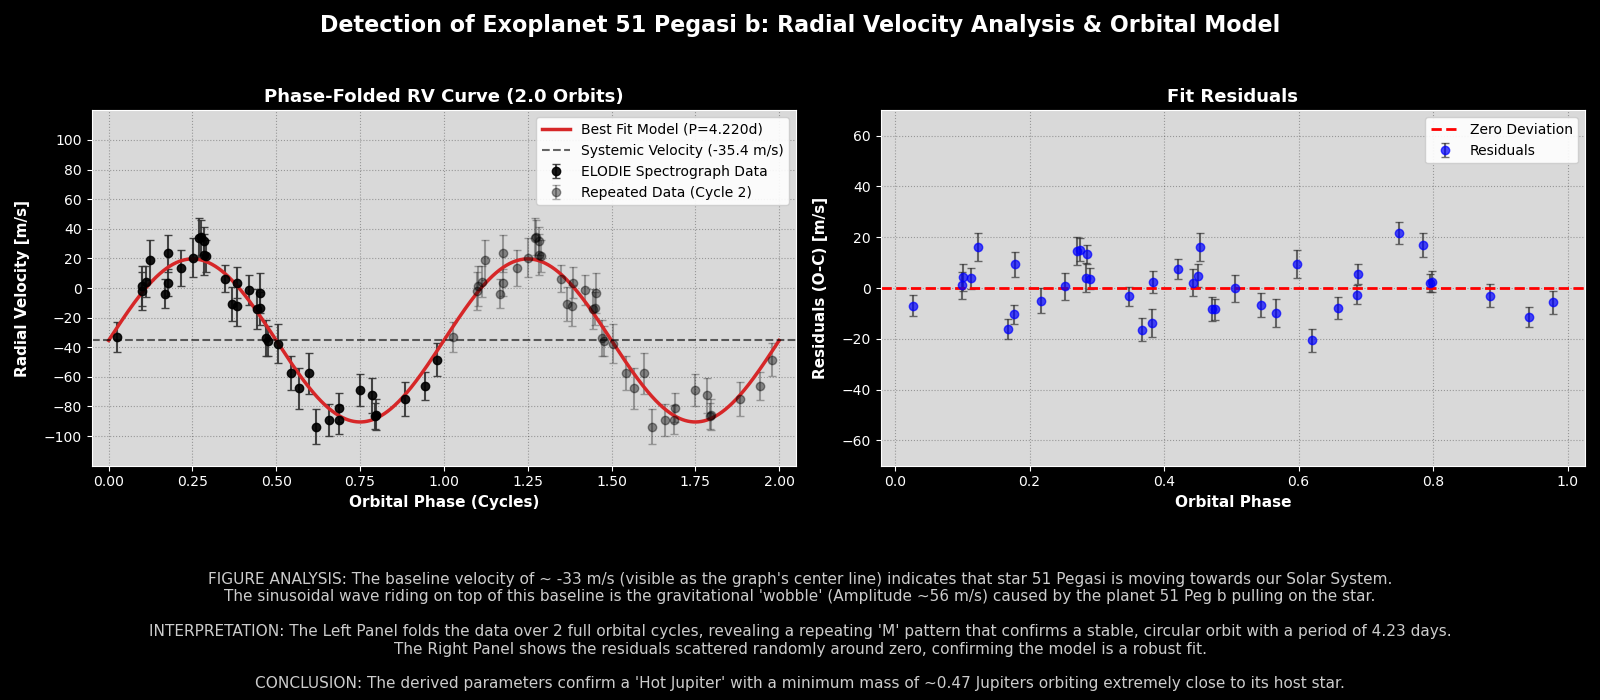

In [23]:
# Simply call this function to run everything
run_analysis()

### 🎯Key Takeaways
    The reduced chi-squared value is .716, which is reasonably close to 1 and thus indicative of a good fit. The randomly-scattered residuals further corrborate this, as they show that errors are random (white noise) and predictions are unbiased (neither systematically high nor low).
    The Result: 51 Pegasi b is a hot Jupiter with:
    - Mass: ~0.47 M_Jupiter (minimum)
    - Orbital period: 4.23 days
    - Distance from star: ~0.05 AU (closer than Mercury to our Sun!)
    - Temperature: ~1200 K (927°C / 1700°F)
    Scientific Impact: This was completely unexpected in 1995 and revolutionized our understanding of how planetary systems form and evolve. 51 Pegasi b became immortalized as the first confirmed exoplanet to orbit around a Sun-like star. Mayor and Queloz proved that planetary systems are quite common in the universe, challenged planetary formation theories, and pioneered the field of exoplanet study. 

### 🤖Statement of AI Collaboration
    A steady collaboration was maintained with multiple AIs (both Gemini and Claude) throughout the duration of the project. It was particularly effective in aiding us to embed complicated physical relationships and equations (namely Kepler's Third Law), but also helped to create more robust and accessible visualizations. The main drawback of this collaboration was encountered when reformatting the code into this Notebook. The AI had suggested packages and libraries that, while effective in a single Python cell in Cursor, were incompatible when run in a Jupyter domain. As a result, the Notebook displays only non-interactive plots through IPython.display. We beleive that, although AI was instrumental in handling the complicated mathematical computations, it's important to adknowledge and address these limitations so that the relationship between AI and human coders can continue to be developed.

### 👨🏻‍💻Statement of Individual Contribution
    Chris developed the core analytical pipeline, implemented the radial velocity fitting algorithm, designed and customized the visualization framework, created the dual-panel phase-folded plotting system with tailored aesthetics including color schemes, and implemented the synthetic data generization function calibrated to match the 1995 ELODIE spectrograph precision, ensuring the dataset accurately reflects the origial observational conditions.
    
    Vivian reconstructed the codebase for compatibility with the JupyterNotebook environment, adapting the original standalone Python script by removing threading and GUI dependencies, implemented the Agg backend for stable plot rendering, integrated the IPython display functionalility, developed markdown documentation and added comments to code cells, and provided scientific context and detailed explanations of the mathetical models and physical principles.